<a href="https://colab.research.google.com/github/rish4/VGG-on-KID/blob/master/VGG_on_KID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 20
batch_size = 32

In [ ]:
train_path = '/content/drive/My Drive/KID dataset - Copy/Training set'
valid_path = '/content/drive/My Drive/KID dataset - Copy/Test set'

In [ ]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')


In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='relu')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


In [ ]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 171 images belonging to 2 classes.
{'Healthy': 0, 'Unhealthy': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 131.17361


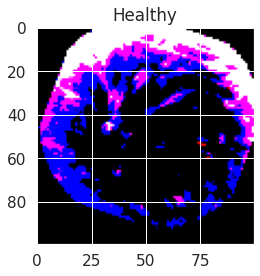

In [ ]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 685 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [ ]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator) 
)

Epoch 1/20
22/22 [==============================] - 8s 358ms/step - loss: 4.5422 - accuracy: 0.5328 - val_loss: 4.3958 - val_accuracy: 0.5263
Epoch 2/20
22/22 [==============================] - 6s 290ms/step - loss: 4.1648 - accuracy: 0.5372 - val_loss: 5.9598 - val_accuracy: 0.5263
Epoch 3/20
22/22 [==============================] - 7s 300ms/step - loss: 5.7747 - accuracy: 0.5255 - val_loss: 8.7917 - val_accuracy: 0.5263
Epoch 4/20
22/22 [==============================] - 7s 299ms/step - loss: 7.1739 - accuracy: 0.5270 - val_loss: 7.3264 - val_accuracy: 0.5263
Epoch 5/20
22/22 [==============================] - 7s 299ms/step - loss: 7.0459 - accuracy: 0.5270 - val_loss: 2.9306 - val_accuracy: 0.5263
Epoch 6/20
22/22 [==============================] - 7s 297ms/step - loss: 7.1516 - accuracy: 0.5270 - val_loss: 7.3264 - val_accuracy: 0.5263
Epoch 7/20
22/22 [==============================] - 7s 303ms/step - loss: 7.3530 - accuracy: 0.5270 - val_loss: 8.7917 - val_accuracy: 0.5263
Epoch 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = valid_generator.classes
    Y_pred = cnn.predict_generator(valid_generator, steps = len(valid_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Abnormal']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

[Summary Statistics]
Accuracy = 45.61% | Precision = 46.43% | Recall = 96.30% | Specificity = 0.00% | F1 Score = 62.65%


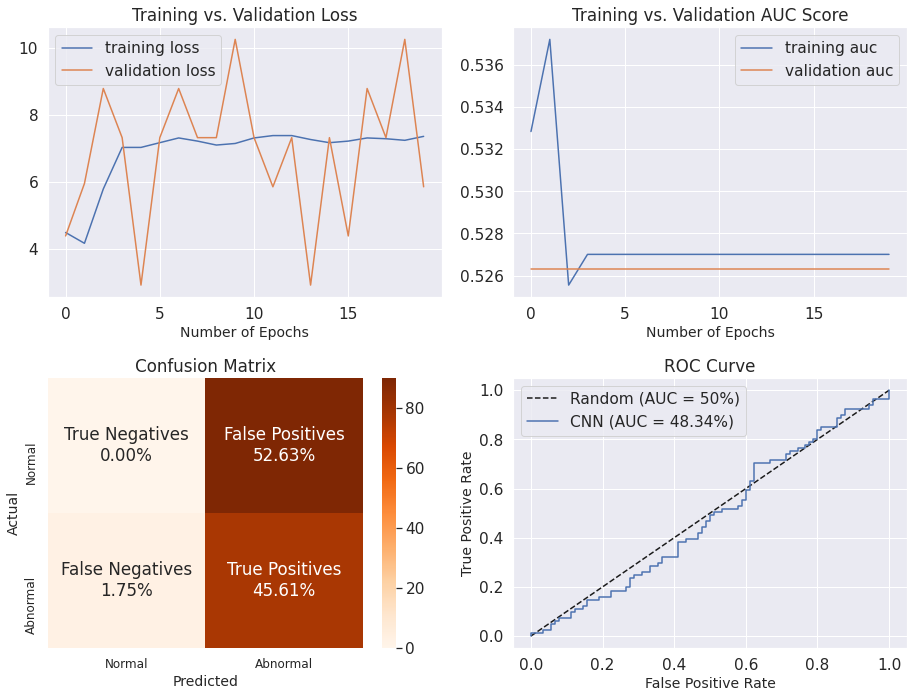

In [ ]:
create_charts(model, r)